# Implementing LSM

In [54]:
import numpy as np
#import math
import matplotlib.pyplot as plt

In [189]:
class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, seed: int):
        """ WRITE TEXT EXPLAINING CLASS...
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.dim = dim
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r*self.Δ)
        self.Z = np.random.normal(0, 1, (self.dim, self.n-1)) # white noise (drawn all at once)
        self.S = np.full((self.dim, self.n), np.nan)  # Allocate space for stock price process, with an extra step for initial value

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for i in range(1,n):
            S[:,i] = S[:,i-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,i-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        increments = (r - 0.5 * σ**2) * Δ + σ * np.sqrt(Δ) * Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:, 1:] = np.cumsum(increments, axis=1)
        S[:,:] += np.log(S0)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)

        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        for i in range(1,n):
            N = np.random.poisson(λ*Δ, dim)  # Poisson process for the number of jumps
            # Jump sizes for each path
            M = np.zeros(dim)
            for j in range(dim):
                if N[j] > 0: # if jump
                    Z_2 = np.random.normal()
                    M[j] = α*N[j] + β*np.sqrt(N[j])*Z_2
            # Calculate the combined diffusion and jump process
            S[:,i] = S[:,i-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,i-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ * Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2

        # Calculate the combined diffusion and jump process for all time steps
        S[:,1:] = np.exp(
            np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)
        )
        self.S = S * S0

        return self.S

    
    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for i in range(1,n):
            S[:,i] = S[:,i-1] + r*S[:,i-1]*Δ + σ*S[:,i-1]**(γ/2)*np.sqrt(Δ)*Z[:,i-1]
        self.S = S

        return self.S
    
    def american_option_LSM(self, poly_degree: int, option_type: str = 'put'):
        """
        American option using the LSM as outlined in Algorithm 1.

        :param poly_degree: x^n, default = 2
        :param option_type: call or put
        """
        assert option_type == 'call' or option_type == 'put', 'Invalid option type.'
        assert len(self.terminal_prices) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        
        # inner values
        if option_type == 'call':
            self.intrinsic_val = np.maximum((S - K), 0.)
        elif option_type == 'put':
            self.intrinsic_val = np.maximum((K - S), 0.)

        # last day cashflow == last day intrinsic value
        cf = self.intrinsic_val[:, -1]

        stopping_rule = np.zeros_like(self.price_array)
        stopping_rule[:, -1] = np.where(self.intrinsic_val[:, -1] > 0, 1, 0)

        # Longstaff and Schwartz iteration
        for t in range(self.no_of_slices - 2, 0, -1):  # fill out the value table from backwards
            # find out in-the-money path to better estimate the conditional expectation function
            # where exercise is relevant and significantly improves the efficiency of the algorithm
            itm_path = np.where(self.intrinsic_val[:, t] > 0)  # <==> self.price_array[:, t] vs. self.K

            cf = cf * np.exp(-self.r[:, t + 1])
            Y = cf[itm_path]
            X = self.price_array[itm_path, t]

            # initialize continuation value
            hold_val = np.zeros(shape=self.simulation_rounds)
            # if there is only 5 in-the-money paths (most likely appear in out-of-the-money options
            # then simply assume that value of holding = 0.
            # otherwise, run regression and compute conditional expectation E[Y|X].
            if len(itm_path) > 5:
                rg = np.polyfit(x=X[0], y=Y, deg=poly_degree)  # regression fitting
                hold_val[itm_path] = np.polyval(p=rg, x=X[0])  # conditional expectation E[Y|X]

            # 1 <==> exercise, 0 <==> hold
            stopping_rule[:, t] = np.where(self.intrinsic_val[:, t] > hold_val, 1, 0)
            # if exercise @ t, all future stopping rules = 0 as the option contract is exercised.
            stopping_rule[np.where(self.intrinsic_val[:, t] > hold_val), (t + 1):] = 0

            # cashflow @ t, if hold, cf = 0, if exercise, cf = intrinsic value @ t.
            cf = np.where(self.intrinsic_val[:, t] > 0, self.intrinsic_val[:, t], 0)

        simulation_vals = (self.intrinsic_val * stopping_rule * self.discount_table).sum(axis=1)
        self.expectation = np.average(simulation_vals)

        print('-' * 64)
        print(
            " American %s Longstaff-Schwartz method (assume polynomial fit)"
            " \n polynomial degree = %i \n S0 %4.1f \n K %2.1f \n"
            " Option Value %4.3f " % (
                option_type, poly_degree, self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

        
    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        for path in self.S:
            plt.plot(time, path, lw=1, alpha=0.25)  # Plot each path with low alpha for visibility

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} GBM Simulation Paths')
        plt.legend()
        
        
        plt.show()

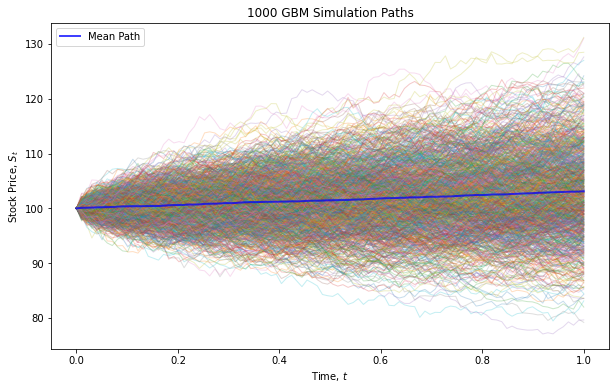

In [201]:
# Initialize the Monte Carlo option pricing with a specific seed
mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=100., K=100., T=1., σ=0.25, dim=1_000, n=100, seed=42)
# Generate 'dim' no. of stock price process paths
#simulated_paths = mc_option_pricing.GeometricBrownianMotion()
#simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
#simulated_paths = mc_option_pricing.MertonJumpDiffusion(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.MertonJumpDiffusion_vec(α=-0.5,β=0.4,λ=0.4)
simulated_paths = mc_option_pricing.CEV(γ=1.5)
mc_option_pricing.plot_paths()  # This will generate and plot the GBM paths

In [ ]:
mc_option_pricing.american_option_LSM(poly_degree = 3, option_type= 'put')

10000
100
100
75
75
1
100
100
89
89
1
100
100
46
46
1
100
100
3
3
1
100
100
87
87
1
100
100
8
8
1
100
100
95
95
1
100
100
1
1
1
100
100
78
78
1
100
100
72
72
1
100
100
88
88
1
100
100
1
1
1
100
100
13
13
1
100
100
7
7
1
100
100
80
80
1
100
100
0
0
1
100
100
99
99
1
100
100
99
99
1
100
100
76
76
1
100
100
20
20
1
100
100
42
42
1
100
100
23
23
1
100
100
99
99
1
100
100
72
72
1
100
100
81
81
1
100
100
43
43
1
100
100
23
23
1
100
100
98
98
1
100
100
3
3
1
100
100
65
65
1
100
100
99
99
1
100
100
34
34
1
100
100
88
88
1
100
100
15
15
1
100
100
79
79
1
100
100
13
13
1
100
100
39
39
1
100
100
75
75
1
100
100
33
33
1
100
100
67
67
1
100
100
75
75
1
100
100
98
98
1
100
100
24
24
1
100
100
44
44
1
100
100
99
99
1
100
100
93
93
1
100
100
3
3
1
100
100
33
33
1
100
100
35
35
1
100
100
19
19
1
100
100
96
96
1
100
100
22
22
1
100
100
70
70
1
100
100
43
43
1
100
100
86
86
1
100
100
99
99
1
100
100
98
98
1
100
100
36
36
1
100
100
99
99
1
100
100
15
15
1
100
100
99
99
1
100
100
72
72
1
100
100
62
62
1
10

2.2287649647701833

NameError: name 'self' is not defined